In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
seed = 45
import lifelines
from lifelines import KaplanMeierFitter

import xgboost as xgb
from xgboost import XGBClassifier
from pdpbox import pdp, get_dataset, info_plots
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score ,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_excel("covid-680.xlsx")
print(data.shape)

(680, 105)


In [3]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object' or 'category' in str(data[i].dtype)):
        data[i] = number.fit_transform(data[i].astype('str'))

In [4]:
X = data.drop(['eidcs', 'eipfg', 'eiior', 'eisdra', 'ID'],axis=1)
y = data['eidcs']

In [5]:
X.shape, y.shape

((680, 100), (680,))

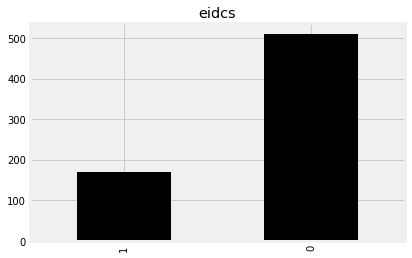

In [6]:
data['eidcs'].value_counts().sort_values().tail(10).plot(kind = "bar", title = "eidcs",color = "black");

In [7]:
data['eidcs'].value_counts()  

0    510
1    170
Name: eidcs, dtype: int64

### SMOTE oversampling

In [8]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=33)

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 33)
X_train, y_train = smote.fit_resample(X_tr,y_tr)
X_test, y_test = smote.fit_resample(X_te,y_te)

print("the number of classes before fit {}".format(Counter(y_tr)))      
print("the number of classes after fit {}".format(Counter(y_train)))    
print("the number of classes before fit {}".format(Counter(y_te)))      
print("the number of classes after fit {}".format(Counter(y_test)))  
         

the number of classes before fit Counter({0: 356, 1: 120})
the number of classes after fit Counter({0: 356, 1: 356})
the number of classes before fit Counter({0: 154, 1: 50})
the number of classes after fit Counter({0: 154, 1: 154})


In [10]:
clas=RandomForestClassifier().fit(X_train,y_train) 

y_pred=clas.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("\n")
print("accuracy Score:")
print(accuracy_score(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

Confusion Matrix:
[[111  43]
 [ 49 105]]


accuracy Score:
0.7012987012987013


              precision    recall  f1-score   support

           0       0.69      0.72      0.71       154
           1       0.71      0.68      0.70       154

    accuracy                           0.70       308
   macro avg       0.70      0.70      0.70       308
weighted avg       0.70      0.70      0.70       308



###  Cross Validation with different models

In [11]:
# get a list of models to evaluate

def get_models():
    models = dict()
    
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])

    # ADA
    rfe = RFE(estimator=AdaBoostClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['ada'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    # DT
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    # gbm
    rfe = RFE(estimator=XGBClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['xgb'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    return models
 

In [12]:
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from numpy import mean
from numpy import std

# evaluate a give model using cross-validation
def evaluate_model(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.701 (0.078)
>ada 0.743 (0.080)
>dt 0.712 (0.067)
>rf 0.721 (0.067)
>xgb 0.716 (0.077)


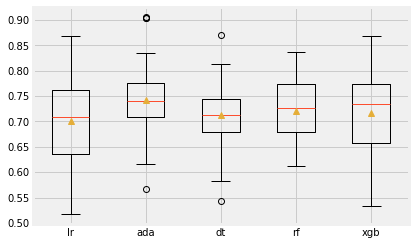

In [13]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### BoxPlot with 10 splits and 30 repeats

In [14]:
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# evaluate a model with a given number of repeats
def evaluate_model(X_train, y_train, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = RandomForestClassifier()
    scores = cross_val_score(model, X_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    return scores

repeats = range(1,31)
results = list()
for r in repeats:
    scores = evaluate_model(X_test, y_test, r)
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    
    results.append(scores)

>1 mean=0.7963 se=0.029
>2 mean=0.7965 se=0.017
>3 mean=0.7913 se=0.014
>4 mean=0.7868 se=0.014
>5 mean=0.7960 se=0.012
>6 mean=0.7883 se=0.009
>7 mean=0.7901 se=0.010
>8 mean=0.7915 se=0.009
>9 mean=0.7890 se=0.008
>10 mean=0.7906 se=0.008
>11 mean=0.7902 se=0.007
>12 mean=0.7824 se=0.007
>13 mean=0.7841 se=0.007
>14 mean=0.7880 se=0.007
>15 mean=0.7892 se=0.006
>16 mean=0.7883 se=0.007
>17 mean=0.7881 se=0.006
>18 mean=0.7899 se=0.006
>19 mean=0.7918 se=0.006
>20 mean=0.7886 se=0.006
>21 mean=0.7874 se=0.005
>22 mean=0.7889 se=0.005
>23 mean=0.7906 se=0.005
>24 mean=0.7921 se=0.005
>25 mean=0.7893 se=0.005
>26 mean=0.7892 se=0.005
>27 mean=0.7932 se=0.005
>28 mean=0.7899 se=0.004
>29 mean=0.7872 se=0.004
>30 mean=0.7879 se=0.004


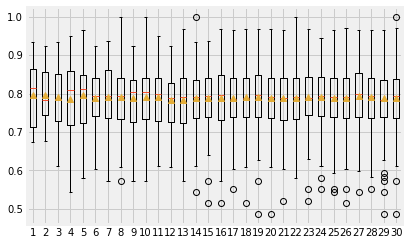

In [15]:
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### ROC with Cross Validation

In [16]:
random_state = np.random.RandomState(0)
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=10,shuffle=False)

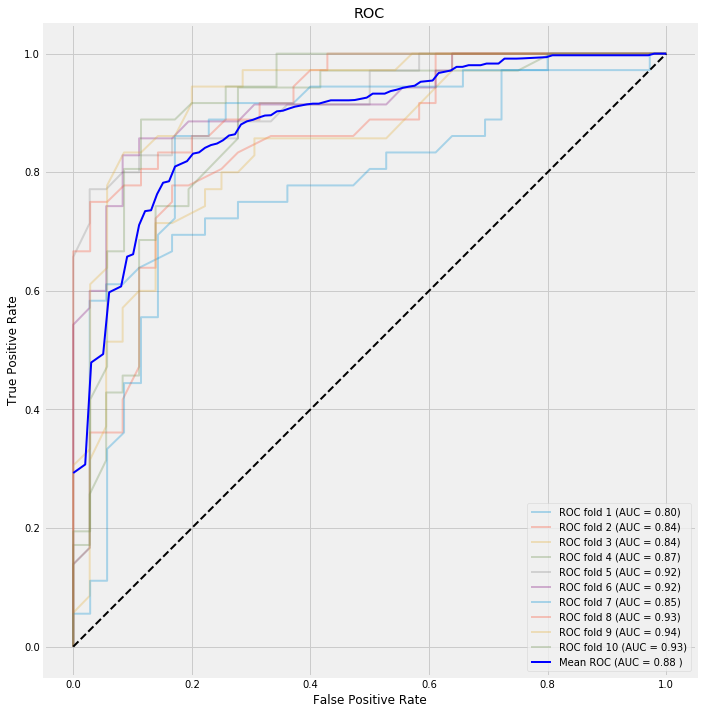

In [17]:
import matplotlib.patches as patches
from scipy import interp

# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
#ax1.add_patch(patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5))
#ax1.add_patch(patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_train,y_train):
    prediction = clf.fit(X_train.iloc[train],y_train.iloc[train]).predict_proba(X_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
#plt.text(0.32,0.7,'More accurate area',fontsize = 12)
#plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()    

### Automatically Select the Number of Features

In [18]:
from sklearn.feature_selection import RFECV

# create pipeline
rfe = RFECV(estimator=RandomForestClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.706 (0.056)


In [19]:
# define RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=1)
# fit RFE
rfe.fit(X_train, y_train)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 12.000
Column: 1, Selected False, Rank: 20.000
Column: 2, Selected False, Rank: 46.000
Column: 3, Selected False, Rank: 43.000
Column: 4, Selected False, Rank: 69.000
Column: 5, Selected False, Rank: 32.000
Column: 6, Selected False, Rank: 29.000
Column: 7, Selected False, Rank: 82.000
Column: 8, Selected False, Rank: 93.000
Column: 9, Selected False, Rank: 4.000
Column: 10, Selected False, Rank: 13.000
Column: 11, Selected False, Rank: 64.000
Column: 12, Selected False, Rank: 71.000
Column: 13, Selected False, Rank: 80.000
Column: 14, Selected False, Rank: 26.000
Column: 15, Selected False, Rank: 19.000
Column: 16, Selected False, Rank: 72.000
Column: 17, Selected False, Rank: 63.000
Column: 18, Selected False, Rank: 6.000
Column: 19, Selected False, Rank: 34.000
Column: 20, Selected False, Rank: 25.000
Column: 21, Selected False, Rank: 3.000
Column: 22, Selected False, Rank: 81.000
Column: 23, Selected False, Rank: 56.000
Column: 24, Selected False, R

### Recursive Feature Elimination with Cross-Validation

In [20]:
rfecv = RFECV(RandomForestClassifier(), step=10, scoring='roc_auc', cv=10, verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30

RFECV(cv=10, estimator=RandomForestClassifier(), scoring='roc_auc', step=10,
      verbose=1)

In [21]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 90


In [22]:
print(X_train.columns[rfecv.ranking_ == 1].values) #Selected Features

['original_shape_Elongation' 'original_shape_Flatness'
 'original_shape_LeastAxisLength' 'original_shape_MajorAxisLength'
 'original_shape_Maximum2DDiameterColumn'
 'original_shape_Maximum2DDiameterRow'
 'original_shape_Maximum2DDiameterSlice'
 'original_shape_Maximum3DDiameter' 'original_shape_MeshVolume'
 'original_shape_MinorAxisLength' 'original_shape_Sphericity'
 'original_shape_SurfaceArea' 'original_shape_SurfaceVolumeRatio'
 'original_shape_VoxelVolume' 'original_firstorder_10Percentile'
 'original_firstorder_90Percentile' 'original_firstorder_Energy'
 'original_firstorder_Entropy' 'original_firstorder_InterquartileRange'
 'original_firstorder_Kurtosis' 'original_firstorder_Maximum'
 'original_firstorder_MeanAbsoluteDeviation' 'original_firstorder_Mean'
 'original_firstorder_Median' 'original_firstorder_Minimum'
 'original_firstorder_Range'
 'original_firstorder_RobustMeanAbsoluteDeviation'
 'original_firstorder_Skewness' 'original_firstorder_Uniformity'
 'original_firstorder_V

In [23]:
#print(X_train.columns[rfecv.ranking_ != 1].values) #Not selected Features

In [27]:
#Optimal number of features: 

train = X_train[['original_shape_Elongation',
                 'original_shape_Flatness',
                 'original_shape_LeastAxisLength',
                 'original_shape_MajorAxisLength',
                 'original_shape_Maximum2DDiameterColumn',
                 'original_shape_Maximum2DDiameterRow',
                 'original_shape_Maximum2DDiameterSlice',
                 'original_shape_Maximum3DDiameter',
                 'original_shape_MeshVolume',
                 'original_shape_MinorAxisLength',
                 'original_shape_Sphericity',
                 'original_shape_SurfaceArea',
                 'original_shape_SurfaceVolumeRatio',
                 'original_shape_VoxelVolume',
                 'original_firstorder_10Percentile',
                 'original_firstorder_90Percentile',
                 'original_firstorder_Energy',
                 'original_firstorder_Entropy',
                 'original_firstorder_InterquartileRange',
                 'original_firstorder_Kurtosis',
                 'original_firstorder_Maximum',
                 'original_firstorder_MeanAbsoluteDeviation',
                 'original_firstorder_Mean',
                 'original_firstorder_Median',
                 'original_firstorder_Minimum',
                 'original_firstorder_Range',
                 'original_firstorder_RobustMeanAbsoluteDeviation',
                 'original_firstorder_Skewness',
                 'original_firstorder_Uniformity',
                 'original_firstorder_Variance',
                 'original_glcm_Autocorrelation',
                 'original_glcm_JointAverage',
                 'original_glcm_ClusterProminence',
                 'original_glcm_ClusterShade',
                 'original_glcm_ClusterTendency',
                 'original_glcm_Contrast',
                 'original_glcm_Correlation',
                 'original_glcm_DifferenceAverage',
                 'original_glcm_DifferenceEntropy',
                 'original_glcm_DifferenceVariance',
                 'original_glcm_JointEnergy',
                 'original_glcm_JointEntropy',
                 'original_glcm_Imc1',
                 'original_glcm_Imc2',
                 'original_glcm_Idm',
                 'original_glcm_Idmn',
                 'original_glcm_Idn',
                 'original_glcm_InverseVariance',
                 'original_glcm_MaximumProbability',
                 'original_glcm_SumEntropy',
                 'original_glcm_SumSquares',
                 'original_glrlm_GrayLevelNonUniformity',
                 'original_glrlm_GrayLevelNonUniformityNormalized',
                 'original_glrlm_GrayLevelVariance',
                 'original_glrlm_HighGrayLevelRunEmphasis',
                 'original_glrlm_LongRunHighGrayLevelEmphasis',
                 'original_glrlm_LongRunLowGrayLevelEmphasis',
                 'original_glrlm_LowGrayLevelRunEmphasis',
                 'original_glrlm_RunEntropy',
                 'original_glrlm_RunLengthNonUniformity',
                 'original_glrlm_RunVariance',
                 'original_glrlm_ShortRunEmphasis',
                 'original_glrlm_ShortRunLowGrayLevelEmphasis',
                 'original_glszm_GrayLevelNonUniformity',
                 'original_glszm_GrayLevelNonUniformityNormalized',
                 'original_glszm_GrayLevelVariance',
                 'original_glszm_HighGrayLevelZoneEmphasis',
                 'original_glszm_LargeAreaEmphasis',
                 'original_glszm_LargeAreaHighGrayLevelEmphasis',
                 'original_glszm_LargeAreaLowGrayLevelEmphasis',
                 'original_glszm_LowGrayLevelZoneEmphasis',
                 'original_glszm_SizeZoneNonUniformity',
                 'original_glszm_SizeZoneNonUniformityNormalized',
                 'original_glszm_SmallAreaEmphasis',
                 'original_glszm_SmallAreaHighGrayLevelEmphasis',
                 'original_glszm_SmallAreaLowGrayLevelEmphasis',
                 'original_glszm_ZoneEntropy',
                 'original_glszm_ZonePercentage',
                 'original_glszm_ZoneVariance',
                 'original_gldm_DependenceEntropy',
                 'original_gldm_DependenceNonUniformity',
                 'original_gldm_DependenceVariance',
                 'original_gldm_GrayLevelNonUniformity',
                 'original_gldm_GrayLevelVariance',
                 'original_gldm_LargeDependenceHighGrayLevelEmphasis',
                 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
                 'original_gldm_LowGrayLevelEmphasis',
                 'original_gldm_SmallDependenceEmphasis',
                 'original_gldm_SmallDependenceHighGrayLevelEmphasis',
                 'original_gldm_SmallDependenceLowGrayLevelEmphasis', ]]        

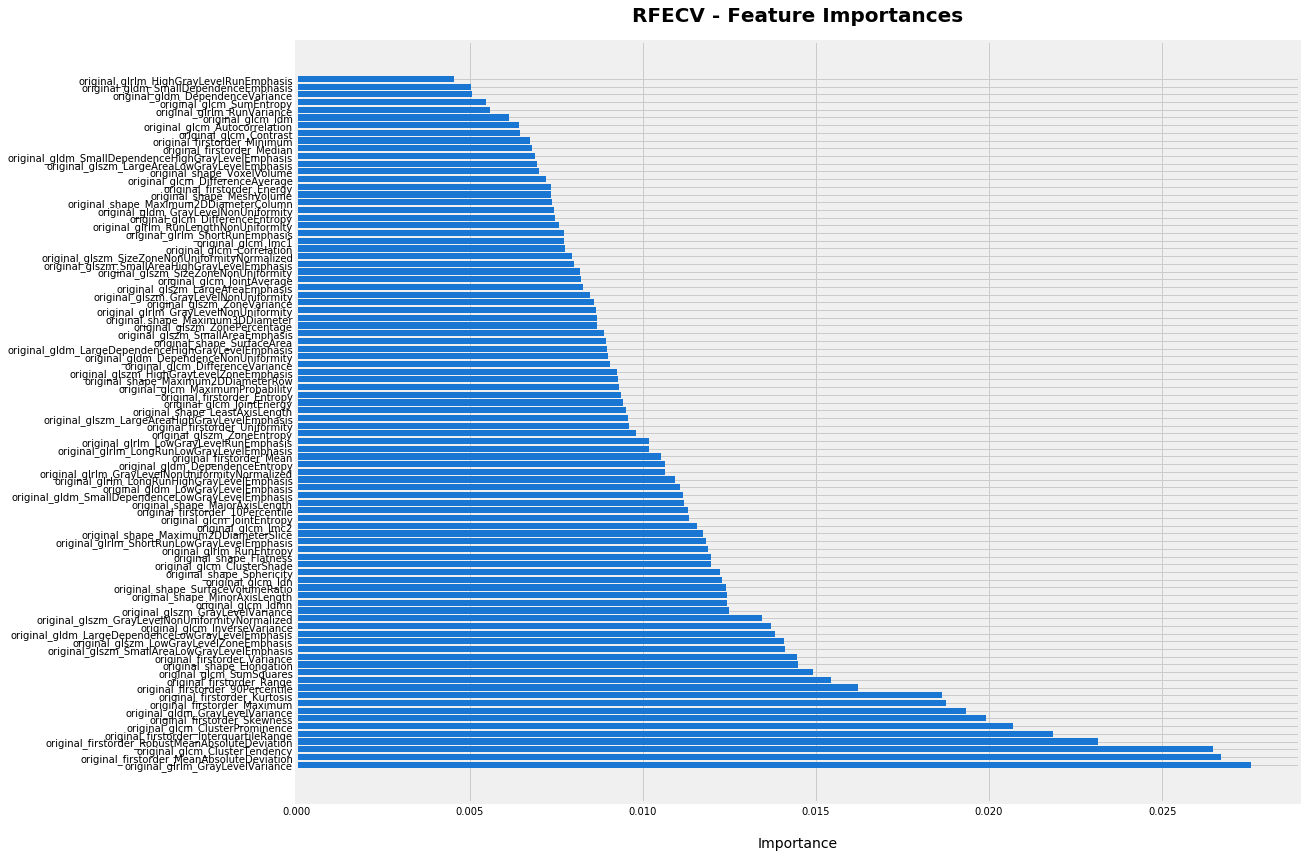

In [28]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [46]:
#plt.figure(figsize=(15,10))
#sns.heatmap(train.corr(),annot=True)
#plt.show()

### Feature Importance for Shape Features

In [30]:
shape_col = [col for col in X_train if col.startswith('original_shap')]   #14
shape_col

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume']

In [31]:
shape = X_train [['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume']]     

In [32]:
rfecv_shape = RFECV(RandomForestClassifier(), step=10, scoring='roc_auc', cv=10, verbose=1)
rfecv_shape.fit(shape, y_train)

Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.
Fitting estimator with 14 features.
Fitting estimator with 4 features.


RFECV(cv=10, estimator=RandomForestClassifier(), scoring='roc_auc', step=10,
      verbose=1)

In [33]:
print('Optimal number of features: {}'.format(rfecv_shape.n_features_))

Optimal number of features: 14


In [34]:
print(shape.columns[rfecv_shape.ranking_ == 1].values) #Selected Features

['original_shape_Elongation' 'original_shape_Flatness'
 'original_shape_LeastAxisLength' 'original_shape_MajorAxisLength'
 'original_shape_Maximum2DDiameterColumn'
 'original_shape_Maximum2DDiameterRow'
 'original_shape_Maximum2DDiameterSlice'
 'original_shape_Maximum3DDiameter' 'original_shape_MeshVolume'
 'original_shape_MinorAxisLength' 'original_shape_Sphericity'
 'original_shape_SurfaceArea' 'original_shape_SurfaceVolumeRatio'
 'original_shape_VoxelVolume']


In [35]:
shape_selected = shape[['original_shape_Elongation',
                        'original_shape_Flatness',
                        'original_shape_LeastAxisLength',
                        'original_shape_MajorAxisLength',
                         'original_shape_Maximum2DDiameterColumn',
                         'original_shape_Maximum2DDiameterRow',
                         'original_shape_Maximum2DDiameterSlice',
                         'original_shape_Maximum3DDiameter',
                        'original_shape_MeshVolume',
                         'original_shape_MinorAxisLength',
                        'original_shape_Sphericity',
                        'original_shape_SurfaceArea',
                        'original_shape_SurfaceVolumeRatio',
                         'original_shape_VoxelVolume']]    

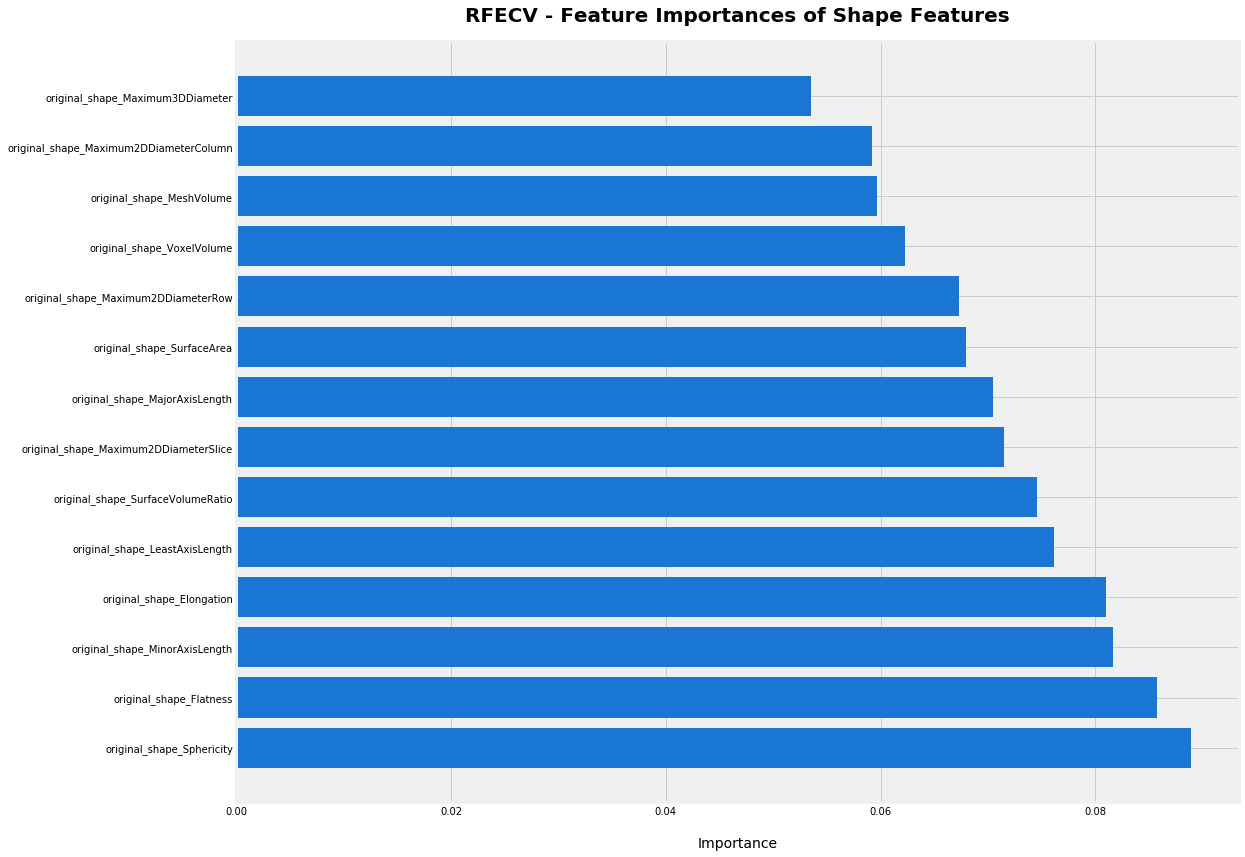

In [36]:
dset = pd.DataFrame()
dset['attr'] = shape_selected .columns
dset['importance'] = rfecv_shape.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances of Shape Features', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

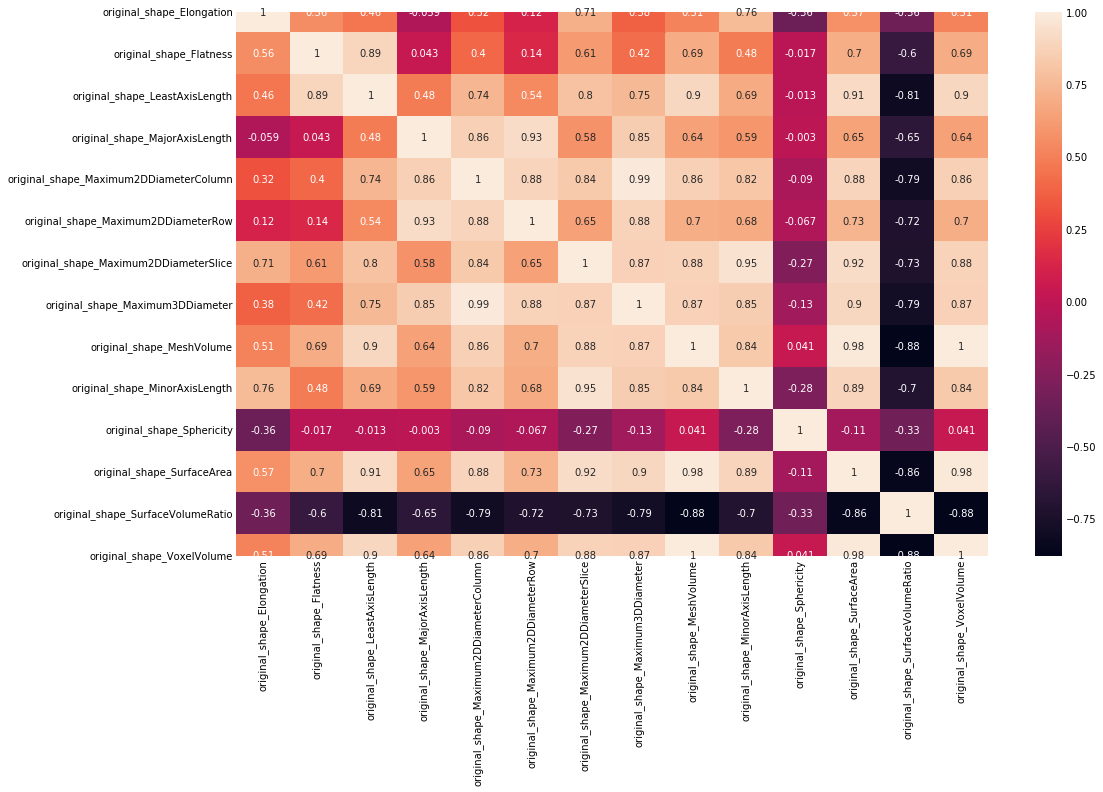

In [37]:
plt.figure(figsize=(15,10))
sns.heatmap(shape_selected.corr(),annot=True)
plt.show()

### Feature Importance for First Order Features

In [38]:
firstorder_col = [col for col in X_train if col.startswith('original_firstorder')]  #18
firstorder_col

['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance']

In [39]:
firstorder = X_train[['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance']]  

In [40]:
rfecv_firstorder = RFECV(RandomForestClassifier(), step=10, scoring='roc_auc', cv=10, verbose=1)
rfecv_firstorder.fit(firstorder, y_train)

Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.


RFECV(cv=10, estimator=RandomForestClassifier(), scoring='roc_auc', step=10,
      verbose=1)

In [41]:
print('Optimal number of features: {}'.format(rfecv_firstorder.n_features_))

Optimal number of features: 18


In [42]:
print(firstorder.columns[rfecv_firstorder.ranking_ == 1].values) #Selected Features

['original_firstorder_10Percentile' 'original_firstorder_90Percentile'
 'original_firstorder_Energy' 'original_firstorder_Entropy'
 'original_firstorder_InterquartileRange' 'original_firstorder_Kurtosis'
 'original_firstorder_Maximum' 'original_firstorder_MeanAbsoluteDeviation'
 'original_firstorder_Mean' 'original_firstorder_Median'
 'original_firstorder_Minimum' 'original_firstorder_Range'
 'original_firstorder_RobustMeanAbsoluteDeviation'
 'original_firstorder_RootMeanSquared' 'original_firstorder_Skewness'
 'original_firstorder_TotalEnergy' 'original_firstorder_Uniformity'
 'original_firstorder_Variance']


In [43]:
firstorder_selected = firstorder[['original_firstorder_10Percentile',
                                  'original_firstorder_90Percentile',
                                   'original_firstorder_Energy',
                                  'original_firstorder_Entropy',
                                  'original_firstorder_InterquartileRange',
                                  'original_firstorder_Kurtosis',
                                  'original_firstorder_Maximum',
                                  'original_firstorder_MeanAbsoluteDeviation',
                                  'original_firstorder_Mean',
                                  'original_firstorder_Median',
                                  'original_firstorder_Minimum',
                                  'original_firstorder_Range',
                                  'original_firstorder_RobustMeanAbsoluteDeviation',
                                  'original_firstorder_RootMeanSquared',
                                  'original_firstorder_Skewness',
                                  'original_firstorder_TotalEnergy',
                                  'original_firstorder_Uniformity',
                                  'original_firstorder_Variance']]    

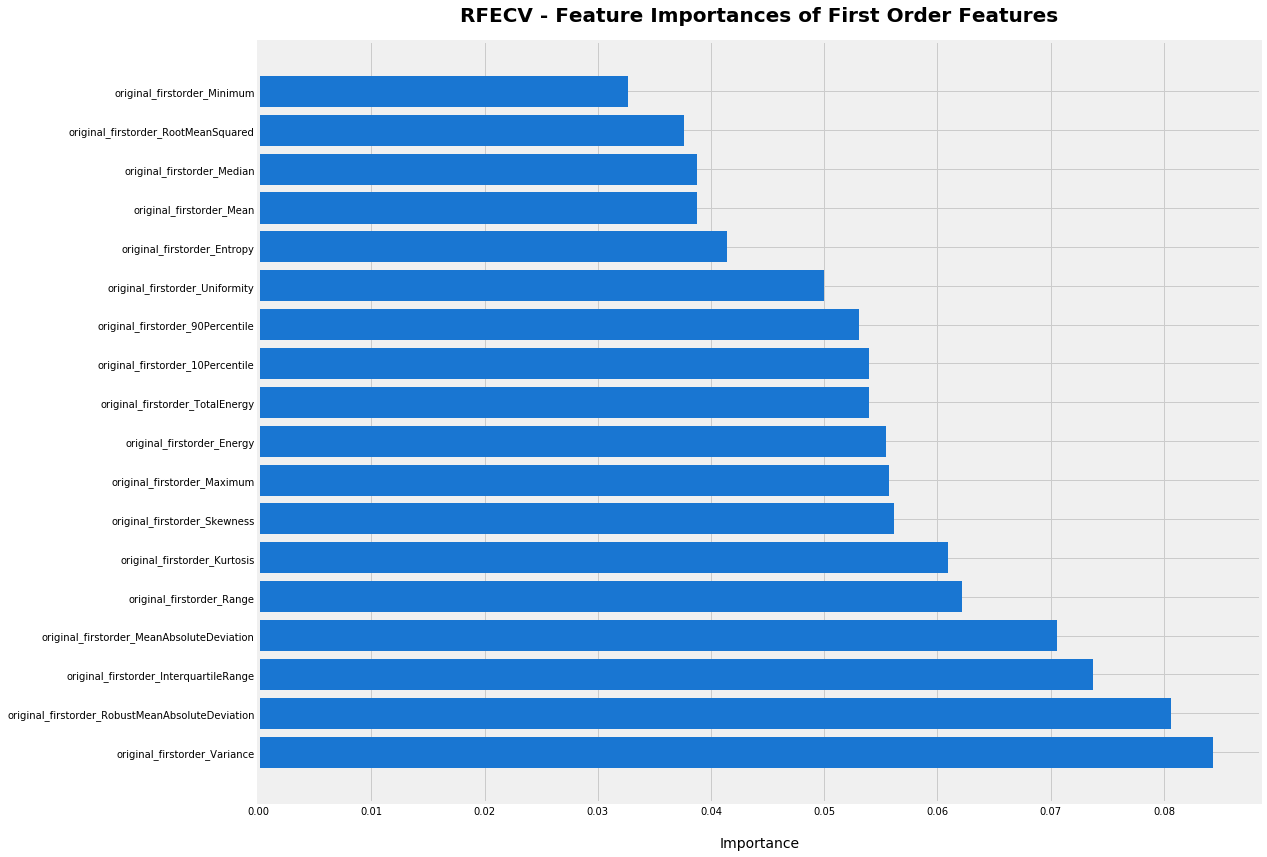

In [44]:
dset = pd.DataFrame()
dset['attr'] = firstorder_selected.columns
dset['importance'] = rfecv_firstorder.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances of First Order Features', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

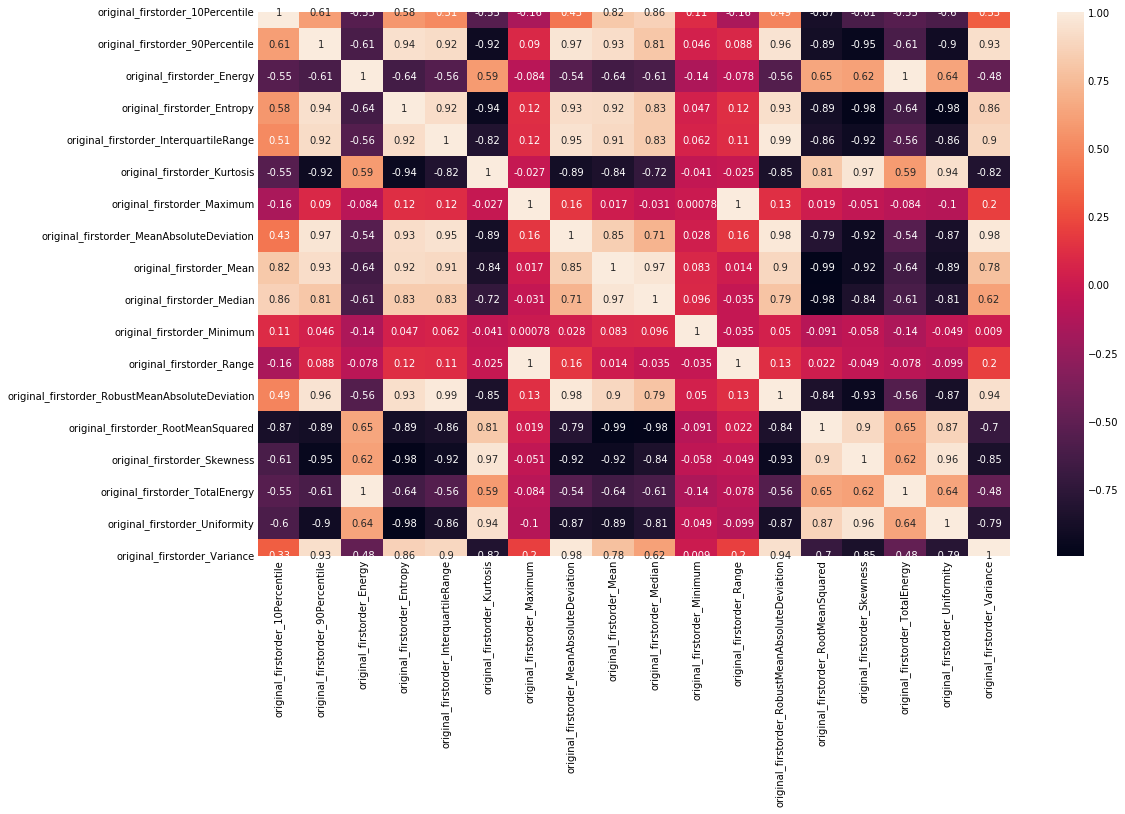

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(firstorder_selected.corr(),annot=True)
plt.show()